#### Note that the model in the textbook assumes constant total pop. I wonder if we can model a dynamic pop?


In [1]:
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Rural-Urban Migration

In this economy there are two regions, urban (U) and rural (R), where the only economic activity in each region is manufacturing and agriculture respectively.

Then total agricultural output is 
$$ Y^A_t = B^A L^R_t $$
and total manaufacturing output is 
$$ Y^M_t = F(K_t, L^U_t) $$

Capital Accumulation is assumed to only happen due to activity in the urban region:
$$ K_{t+1} = sF(K_t, L^U_t)+(1-\delta) K_t $$

Migration Dynamics follow
$$
L^R_{t+1} - L^R_t = \begin{cases} 
\mu L^R_t  &  \text{if }  w^U_t > w^R_t \\
\in [0, \mu L^R_t] &    \text{if }  w^U_t = w^R_t \\
0&   \text{if }  w^U_t < w^R_t \\
\end{cases}
$$

where 
$$ w^U_t = \frac{\partial F(K(t), L^U_t)}{\partial L} \text{, and } w^R_t = B^A $$ 

Note $\mu$ is typically small.

In [ ]:
class UrbanMigration:
    def __init__(
        self,
        A = 1, 
        alpha = 0.5,
        B = 1.25,
        delta = 0.05,
        mu = 0.01,
        s = 0.3,
        l_u_0 = 0.01,
        l_r_0 = 0.99 
    ):
        """Rural to Urban Migration Economic Model.

        This class simulates the model detailed by Lewis (1954). 

        Parameters
        ----------
        A : int, optional
            Factor productivity for urban production function (cobb-douglas), by default 1
        alpha : float, optional
            Power value in urban production function (cobb-douglas) for Capital, by default 0.5
        B : int, optional
            Factor productivity for rural production function(Y=BL), by default 1
        delta : float, optional
            Capital depreciation rate, by default 0.05
        mu : float, optional
            Migration rate, ususally small, by default 0.01
        s : float, optional
            Savings rate, by default 0.3
        l_u_0 : float, optional
            Urban population at time t=0, by default 0.01
        l_r_0 : float, optional
            Rural population at time t=0, by default 0.99
        """
        self.A = A  # Factor productivity for urban production function. 
        self.alpha = alpha
        self.B = B  # Factor in the rural production function.
        self.delta = delta  # Capital depreciation rate.
        self.mu = mu  # Migration Rate
        self.s = s  # Saving Rate

        self.l_r = [l_r_0]  
        self.l_u = [l_u_0]

        self.K = [1]

        self.y_a = [self.rural_production_func(l_r_0)]  # Agricultural Output for rural
        self.y_m = [self.urban_production_func(self.K[0], l_u_0)]  # Manufacturing output for urban

        self.w_r = [self.B]
        self.w_u = [self.urban_wage(self.K[0], l_u_0)]

        self.gini = [self.two_group_gini(self.l_r[-1], self.l_u[-1], self.w_r[-1], self.w_u[-1])]

    def __repr__(self):
        return (f"UrbanMigration(A={self.A}, alpha={self.alpha}, B={self.B}, "
                f"delta={self.delta}, mu={self.mu}, s={self.s}, "
                f"l_u_0={self.l_u[0]}, l_r_0={self.l_r[0]}, "
                f"Initial Capital={self.K[0]}, Initial Rural Output={self.y_a[0]:.2f}, "
                f"Initial Urban Output={self.y_m[0]:.2f}, "
                f"Initial Rural Wage={self.w_r[0]:.2f}, Initial Urban Wage={self.w_u[0]:.2f}, "
                f"Initial Gini Coefficient={self.gini[0]:.2f})")
        

    def rural_production_func(self, l_r_t: float) -> float:
        return self.B * l_r_t
    
    def urban_production_func(self, K_t: float, l_u_t: float) -> float:
        return self.A * (K_t ** (self.alpha)) * (l_u_t ** (1-self.alpha))
    
    def urban_wage(self, K_t: float, l_u_t: float) -> float:
        return self.A * (1-self.alpha) * (K_t / l_u_t) ** self.alpha
    
    def two_group_gini(self, L1, L2, W1, W2) -> float:
        """
        Calculates the gini for two sub-groups, each of which earns equal incomes.
        """

        numerator = L1 * L2 * abs(W1 - W2)
        denominator = (L1 + L2) * (L1 * W1 + L2 * W2)

        return numerator / denominator
    
    def simulate(self, t):
        for _ in range(t):
            # Note tp1 means time t plus 1
            k_tp1 = self.s * self.urban_production_func(self.K[-1], self.l_u[-1]) + (1-self.delta) * self.K[-1]
            self.K.append(k_tp1)
            
            if self.w_r[-1] > self.w_u[-1]:
                migration_count = 0
            elif self.w_r[-1] < self.w_u[-1]:
                
                migration_count = self.mu * self.l_r[-1]
            else:
                migration_count = random.uniform(0, self.mu * self.l_r[-1])

            l_r_tp1 = self.l_r[-1] - migration_count
            l_u_tp1 = self.l_u[-1] + migration_count
            self.l_r.append(l_r_tp1)
            self.l_u.append(l_u_tp1)

            w_r_tp1 = self.B
            w_u_tp1 = self.urban_wage(k_tp1, l_u_tp1)
            self.w_r.append(w_r_tp1) 
            self.w_u .append(w_u_tp1)

            y_r_tp1 = self.rural_production_func(l_r_tp1)
            y_u_tp1 = self.urban_production_func(k_tp1, l_u_tp1)
            self.y_a.append(y_r_tp1) 
            self.y_m.append(y_u_tp1)

            self.gini.append(self.two_group_gini(l_r_tp1, l_u_tp1, w_r_tp1, w_u_tp1))

        print(f"{t} periods simulated. Current time period: {len(self.K)}")

    
    def plot(self, wages=True, population=True, gini=True, income=True, figsize=None, save=False, save_name='urbanisation.png'):
        """
        Plots the dynamics of this economy over time. 

        Parameters
        ----------
        wages : bool, optional
            Include a subplot for wages, by default True
        population : bool, optional
            Include a subplot for wages, by default True
        gini : bool, optional
            Include a subplot for wages, by default True
        income : bool, optional
            Include a subplot for wages, by default True
        figsize : _type_, optional
            Figure size, by default None
        save : bool, optional
            If True, saves the plot to a file.
        save_name : str, optional
            File name for saved plot, by default 'urbanisation.png'
        """
        figsize=None
        plot_params = []
        if wages:
            plot_params.append((['Rural', 'Urban'], 'Wages', 'Wages', [self.w_r, self.w_u]))
        if population:
            plot_params.append((['Rural', 'Urban'], 'Population', 'Population', [self.l_r, self.l_u]))
        if income:
            plot_params.append((['Rural', 'Urban'], 'Income', 'Income', [self.y_a, self.y_m]))
        if gini:
            plot_params.append((['Gini'], 'Gini Coefficient', 'Gini', [self.gini]))

        n = len(plot_params)
        figsize=(4*n, 5) if not figsize else figsize
        
        # Create subplots
        fig, axes = plt.subplots(1, n, figsize=figsize)  
        if n == 1: 
            axes = [axes]
        
        for idx, (labels, title, y_label, datas) in enumerate(plot_params):
            for label, data in zip(labels, datas):
                axes[idx].plot(data, label=label)

            axes[idx].set_title(title)
            axes[idx].set_xlabel('Time')
            axes[idx].set_ylabel(y_label)
            axes[idx].legend()
            axes[idx].grid(alpha=0.8)

        plt.tight_layout()
        
        if save:
            plt.savefig(save_name, transparent=True)

        plt.show()


150 periods simulated. Current time period: 151


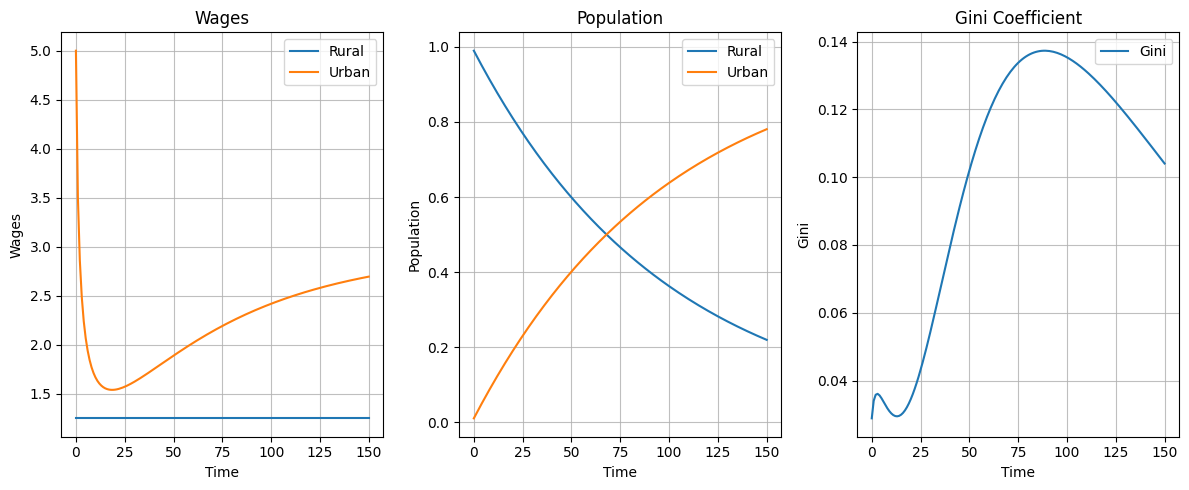

In [7]:
urban_migration = UrbanMigration(B=1.25)

urban_migration.simulate(150)
urban_migration.plot(income=False, save=True)